In [35]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from aeon.datasets import load_airline
from aeon.utils.plotting import plot_series
from aeon.forecasting.model_selection import temporal_train_test_split
from aeon.forecasting.arima import ARIMA
from aeon.performance_metrics.forecasting import mean_absolute_percentage_error
from aeon.forecasting.model_selection import ExpandingWindowSplitter, SlidingWindowSplitter
from utils import plot_windows, get_windows

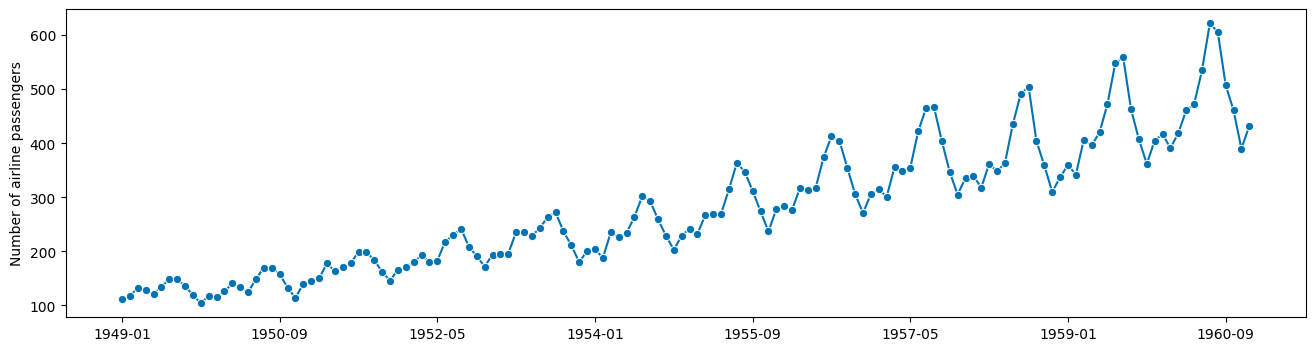

In [36]:
y = load_airline()
plot_series(y)
plt.show()

In [37]:
y_train, y_test = temporal_train_test_split(y, test_size=36)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

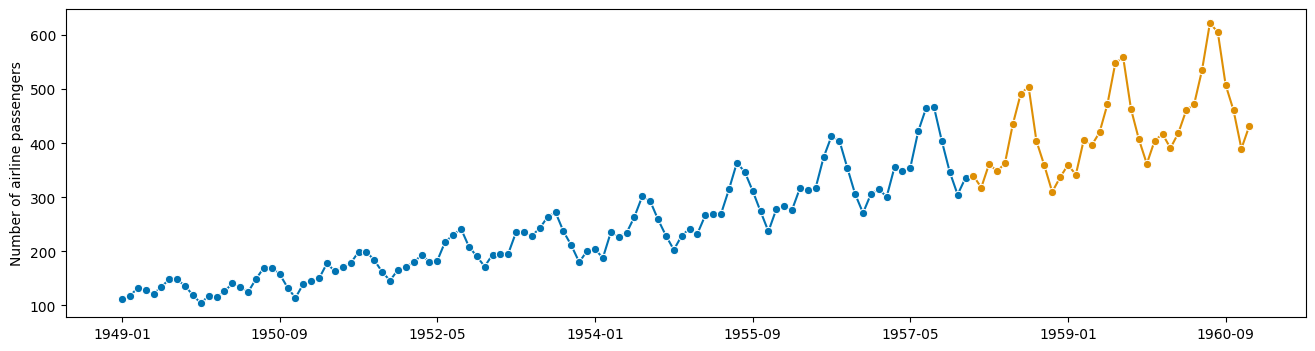

In [38]:
plot_series(y_train, y_test)

In [39]:
fh=np.arange(len(y_test)) + 1
print(fh)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]


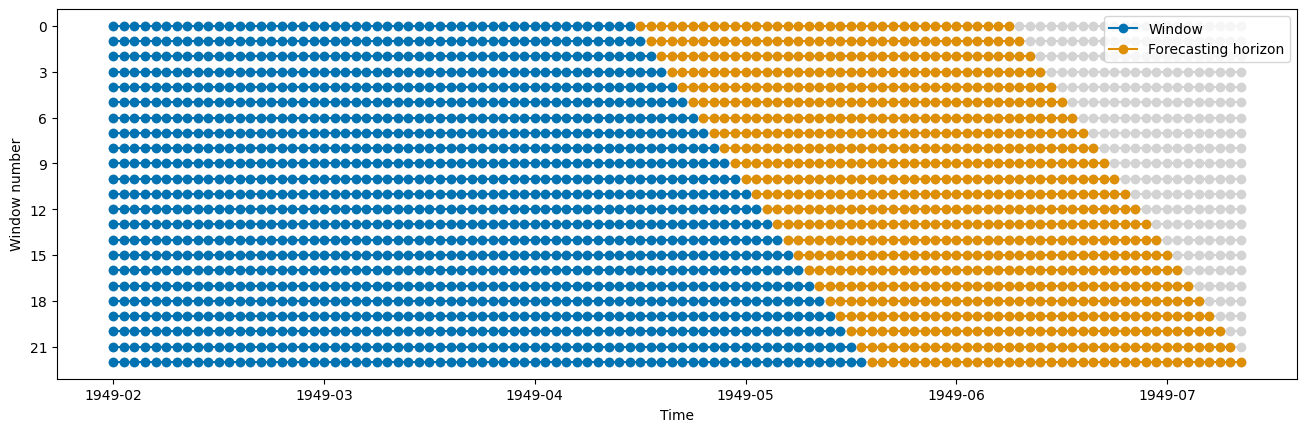

In [40]:
splitter = ExpandingWindowSplitter(fh=fh, initial_window=50, step_length=1)
train_windows, test_windows = get_windows(y_train, splitter)
plot_windows(y_train, train_windows, test_windows)

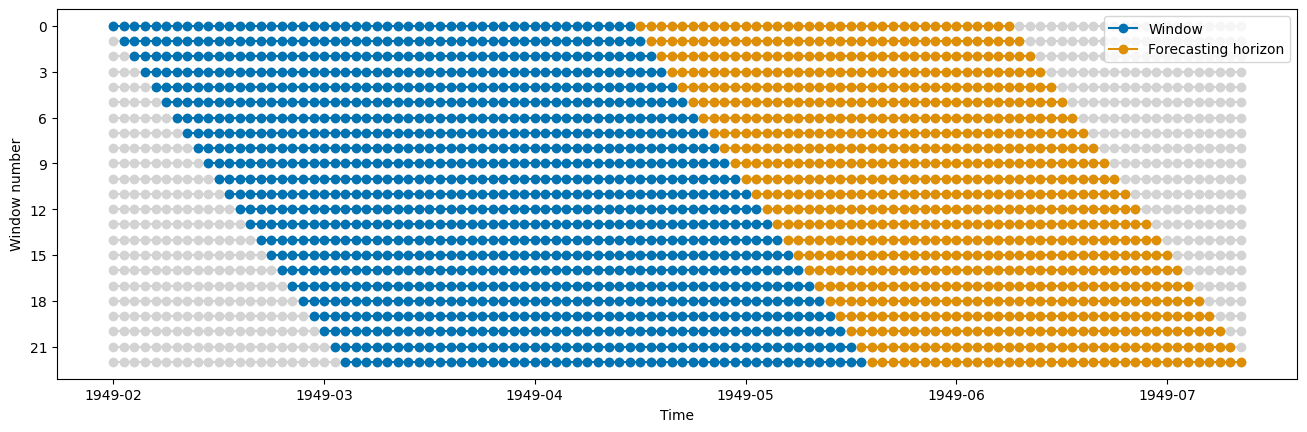

In [41]:
splitter = SlidingWindowSplitter(fh=fh, window_length=50, step_length=1)
train_windows, test_windows = get_windows(y_train, splitter)
plot_windows(y_train, train_windows, test_windows)

In [42]:
forecaster = ARIMA(order=(1, 1, 0), seasonal_order=(1, 1, 0, 12))  
splitter = ExpandingWindowSplitter(fh=fh, initial_window=50, step_length=1)
cvs = splitter.split(y_train)

datas = []
for ix, iy in cvs:
    # Get data
    y_train_cv = y_train.iloc[ix]
    y_test_cv = y.iloc[iy]
    # Train the model
    forecaster.fit(y_train_cv)
    # Predict
    y_pred_cv = forecaster.predict(fh)
    # Evaluate
    mape = mean_absolute_percentage_error(y_test_cv, y_pred_cv)
    # storing the results
    data = {"mape": mape}
    datas.append(data)

df = pd.DataFrame.from_dict(datas)
display(df.describe())

,mape
count,23.000000
mean,0.123929
std,0.054862
min,0.047597
25%,0.080866
50%,0.113940
75%,0.154821
max,0.246596


In [43]:
sOrders = np.arange(8, 15)

datas = []
for sOrder in sOrders:
    
    forecaster = ARIMA(order=(1, 1, 0), seasonal_order=(1, 1, 0, sOrder))
    # Need to recompute the splitter because the iterator is exhausted
    splitter = ExpandingWindowSplitter(fh=fh, initial_window=50, step_length=1) 
    cvs = splitter.split(y_train)
    
    datasTemp = [] 
    for ix, iy in cvs:
        # Get data
        y_train_cv = y_train.iloc[ix]
        y_test_cv = y.iloc[iy]
        # Train the model
        forecaster.fit(y_train_cv)
        # Predict
        y_pred_cv = forecaster.predict(fh)
        # Evaluate
        mape = mean_absolute_percentage_error(y_test_cv, y_pred_cv)
        # storing the results
        data = {"mape": mape}
        datasTemp.append(data)

    dfTemp = pd.DataFrame.from_dict(datasTemp)
    data = {
        "sOrder": sOrder,
        "mapeMean": dfTemp["mape"].mean(),
        "mapeStd": dfTemp["mape"].std()
    }
    datas.append(data)

df = pd.DataFrame.from_dict(datas)
display(df)

,sOrder,mapeMean,mapeStd
0,8,0.388776,0.215902
1,9,0.348831,0.180627
2,10,0.316190,0.168586
3,11,0.226147,0.101023
4,12,0.123929,0.054862
5,13,0.224534,0.080706
6,14,0.289892,0.133070


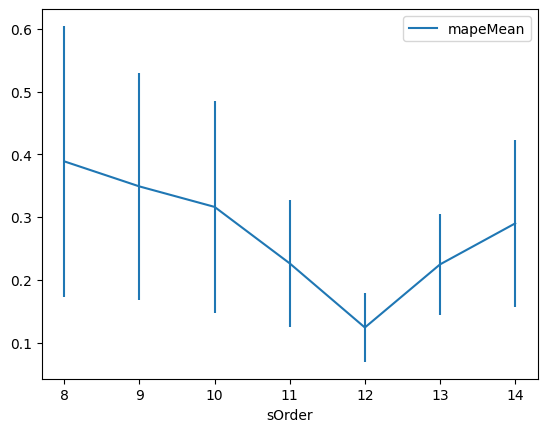

In [44]:
df.plot(x="sOrder", y="mapeMean", yerr="mapeStd")
plt.show()

In [45]:
sOrder_best = df.sort_values(by="mapeMean").iloc[0]['sOrder']
print(sOrder_best)
forecaster = ARIMA(order=(1, 1, 0), seasonal_order=(1, 1, 0, sOrder_best))
forecaster.fit(y_train)

12.0


ARIMA(order=(1, 1, 0), seasonal_order=(1, 1, 0, 12.0))

In [46]:
y_pred = forecaster.predict(fh)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"mape: {mape}")

mape: 0.04267111641819974
